In [92]:
from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import polygon
from matplotlib import pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pylab as pylab
import cv2

In [93]:
# miss_table_path = "..\\..\\datasets\\table\\miss_metadata.csv"
# clean_table_path = "..\\..\\datasets\\table\\clean_metadata.csv"
# miss_png_path = "..\\..\\datasets\\image\\miss_png\\"
# clean_png_path = "..\\..\\datasets\\image\\clean_png\\"
# miss_preprocess_png = "..\\..\\datasets\\image\\miss_preprocess_png\\"
# clean_preprocess_png = "..\\..\\datasets\\image\\clean_preprocess_png\\"

# miss_ori = list(map(lambda x: x.split('/')[9], pd.read_csv(miss_table_path, dtype=str)['anon_dicom_path']))
# miss_ori_pos = list(map(lambda x: x, pd.read_csv(miss_table_path, dtype=str)['ViewPosition']))
# miss = zip(miss_ori, miss_ori_pos)
# clean_ori = list(map(lambda x: x.split('/')[9], pd.read_csv(clean_table_path, dtype=str)['anon_dicom_path']))
# clean_ori_pos = list(map(lambda x: x, pd.read_csv(clean_table_path, dtype=str)['ViewPosition']))
# clean = zip(clean_ori, clean_ori_pos)

def bilateral_filter(ori_path):  
    ori_img = cv2.imread(ori_path, 0)
    # print(ori_path,'to', bil_path)
    bil_img = cv2.bilateralFilter(ori_img, 9, 150, 150)
    return bil_img

def select_breast_area(bil_img):
    # binarization: use thresholding to create a binary mask
    th, img_binary = cv2.threshold(bil_img, 7, 255, cv2.THRESH_BINARY)
    # expand the border of white contours (dliate -> open)
    kernel = np.ones((21,21),np.uint8)
    img_opening = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel)
    # deciding the breast area with binary mask
    img_masked = cv2.bitwise_and(bil_img,img_opening)
    return img_masked

def clahe(img):
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit =3.0, tileGridSize=(4,4))
    cl_img = clahe.apply(img)
    ret, thresh3 = cv2.threshold(cl_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cl_img

def apply_canny(image):
    # img = cv2.medianBlur(image, 9)                 # 模糊化，去除雜訊
    output = cv2.Canny(image, 10, 35) 
    return output

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    # print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        # print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle + 0.0001)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle + 0.0001)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

def shortlist_lines(lines):
    MIN_ANGLE = 15
    MAX_ANGLE = 90
    MIN_DIST  = 20
    MAX_DIST  = 1000
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    # print('\nShorlisted lines')
    # for i in shortlisted_lines:
    #     print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    # print(shortlisted_lines)
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

def hough(image, cla_image):
    rows, cols = image.shape

    # Step 2: Contour detection using Canny filter
    img = cv2.medianBlur(image, 33)  
    canny_image = apply_canny(img)

    # Step 3: Linear aperture filtering
    filtered_image = cv2.filter2D(canny_image, -1, np.array([[0, 2, 0], [2, 2, 2], [0, 2, 0]]))

    # Step 4: Line detection using Hough Transform
    lines = get_hough_lines(filtered_image)
    shortlisted_lines = shortlist_lines(lines)
    
    # Step 5: Apply the Hough mask to the region of interest
    rr, cc = remove_pectoral(shortlisted_lines)
    # Create a boolean mask for the conditions
    mask = (rr < rows) & (cc < cols)
    # Set values to 0 where the conditions are met
    cla_image[rr[mask], cc[mask]] = 0
    return cla_image

test_pic = '../../datasets/image/clean_preprocess_png/1.2.826.0.1.3680043.8.498.25283982197844949664220173084845491635.dcm.png'
new_path = "../../datasets/image/test/test6_clahe.png"

bil_img = bilateral_filter(test_pic)
masked_img = select_breast_area(bil_img)
cl_img = clahe(masked_img)
cv2.imwrite(new_path, cl_img)


True

In [94]:
def apply_canny(image):
    # img = cv2.medianBlur(image, 9)                 # 模糊化，去除雜訊
    output = cv2.Canny(image, 10, 35) 
    return output

In [95]:
def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [96]:
def shortlist_lines(lines):
    MIN_ANGLE = 20
    MAX_ANGLE = 90
    MIN_DIST  = 100
    MAX_DIST  = 1300
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [97]:
def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    # print(shortlisted_lines)
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [98]:
def threshold_mask(img):
    thres_img = np.zeros_like(img)
    # Define a threshold value
    threshold_value = 160

    # Iterate over each pixel in the image
    for i in range(thres_img.shape[0]):
        for j in range(thres_img.shape[1]):
            # Apply threshold to each pixel individually
            if thres_img[i, j] > threshold_value:
                thres_img[i, j] = 255
            else:
                thres_img[i, j] = 0

    return thres_img

In [99]:
def display_image(image, cla_image):
    rows, cols = image.shape
    # print(image)
    # blurred = cv2.GaussianBlur(image, (15, 15), 0)
    # img_binary = threshold_mask(image)
    img = cv2.medianBlur(image, 33)  
    canny_image = apply_canny(img)
    # canny_image = cv2.Sobel(image, -1, 1, 1, 1, 3)
    filtered_image = cv2.filter2D(canny_image, -1, np.array([[0, 2, 0], [2, 2, 2], [0, 2, 0]]))
    lines = get_hough_lines(filtered_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Blurred')
    axes[0].imshow(img, cmap=pylab.cm.gray)
    axes[0].axis('on') 

    axes[1].set_title('Canny')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on') 
    
    axes[2].set_title('Hough Lines on Canny Edge Image')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[3].set_title('Shortlisted Lines')
    axes[3].imshow(canny_image, cmap=pylab.cm.gray)
    axes[3].axis('on')
    axes[3].set_xlim(0,image.shape[1])
    axes[3].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[3].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)

    # Create a boolean mask for the conditions
    mask = (rr < rows) & (cc < cols)

    # Set values to 0 where the conditions are met
    cla_image[rr[mask], cc[mask]] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(cla_image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    plt.show() 

    new_path = "../../datasets/image/test/out.png"
    cv2.imwrite(new_path, cla_image)


All hough lines
Angle: -90.00, Dist: -18.00
Angle: 0.00, Dist: 1106.00
Angle: 22.00, Dist: 1035.00
Angle: -6.00, Dist: 35.00
Angle: 6.00, Dist: 980.00
Angle: -9.00, Dist: 78.00
Angle: -8.00, Dist: 223.00
Angle: -8.00, Dist: 7.00
Angle: -12.00, Dist: 351.00
Angle: 1.00, Dist: 325.00
Angle: -4.00, Dist: 369.00
Angle: 15.00, Dist: 1004.00
Angle: 45.00, Dist: 2080.00
Angle: -2.00, Dist: 287.00
Angle: -17.00, Dist: 191.00
Angle: -2.00, Dist: 108.00
Angle: -19.00, Dist: -16.00
Angle: -12.00, Dist: 338.00
Angle: 8.00, Dist: 449.00
Angle: -20.00, Dist: -51.00
Angle: 8.00, Dist: 1086.00
Angle: -13.00, Dist: 300.00
Angle: -7.00, Dist: 176.00
Angle: 7.00, Dist: 409.00
Angle: 11.00, Dist: 991.00
Angle: -15.00, Dist: 270.00
Angle: -20.00, Dist: 100.00
Angle: 4.00, Dist: 358.00
Angle: -7.00, Dist: 260.00
Angle: 1.00, Dist: 339.00
Angle: -2.00, Dist: 139.00
Angle: 27.00, Dist: 1410.00
Angle: 3.00, Dist: 429.00
Angle: -22.00, Dist: -80.00
Angle: -7.00, Dist: 52.00
Angle: 3.00, Dist: 150.00
Angle: -16

C:\Users\fenyu\AppData\Local\Temp\ipykernel_12664\3405076807.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
C:\Users\fenyu\AppData\Local\Temp\ipykernel_12664\3405076807.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)


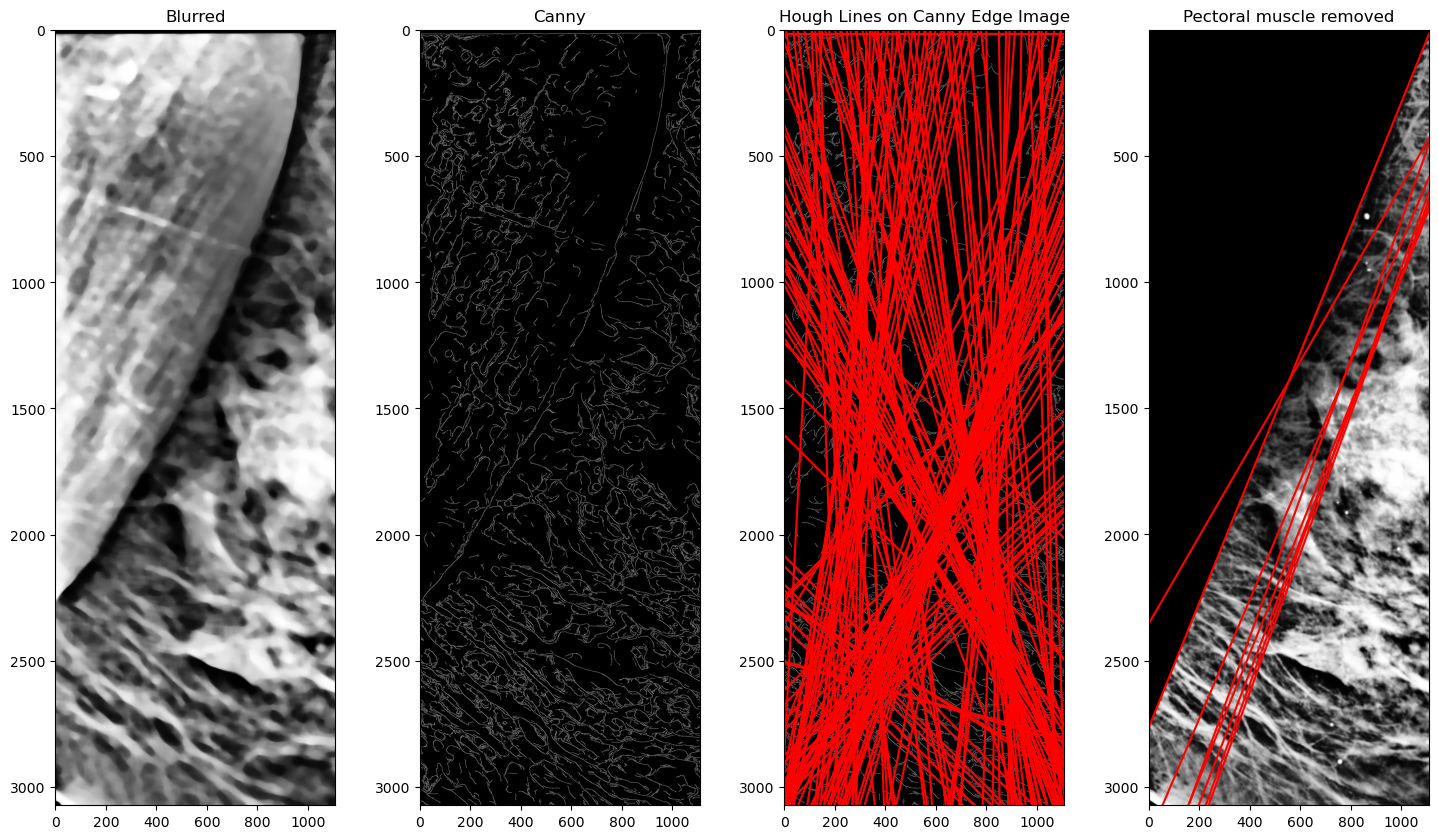

In [100]:
test_pic = "../../datasets/image/test/test6_clahe.png"
clahe_pic = "../../datasets/image/test/test6_clahe.png"
cla_image = cv2.imread(clahe_pic, 0)
image = cv2.imread(test_pic, 0)
rows, cols = image.shape
roi = image[:3 * rows//4, :cols//3]
# print(roi)
display_image(roi, cla_image)